# Distinguish images of dogs from cats
![](https://storage.googleapis.com/kaggle-competitions/kaggle/5441/logos/front_page.png)

## Connect Google Drive & Install Required Libraries

In [1]:
root_dir = ''
try:
    from google.colab import drive, files
    drive.mount('/content/drive')
    root_dir = '/content/drive/My Drive/Colab Notebooks/tensorflow-2-projects/'

    # To upload kaggle.json to mounted directory
    # files.upload();

    # Create directory for kaggle.json key file and copy file
    !mkdir -p ~/.kaggle
    # In my case, 'Colab Notebooks' directory already contains my kaggle.json
    !cp '{root_dir}../kaggle.json' ~/.kaggle/

    # Change the permission
    !chmod 600 ~/.kaggle/kaggle.json
    
    # Install the require libraries
    print('~'*50)
    !pip install kaggle
    print('~'*50)
    !pip install scikit-plot
    print('~'*50)
    !pip install tensorflow-gpu
except:
    print('No GOOGLE DRIVE connection. Using local dataset(s).')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
     |████████████████████████████████| 380.8MB 47kB/s 
     |████████████████████████████████| 3.8MB 51.1MB/s 
     |████████████████████████████████| 450kB 55.3MB/s 
     |████████████████████████████████| 81kB 11.6MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have te

## Import Libraries

In [0]:
import os, os.path, shutil, sys, random, gc
import glob, tqdm
from zipfile import ZipFile
from tarfile import TarFile

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import pickle

import scikitplot as skplt

import tensorflow as tf

In [3]:
print(tf.version.VERSION)
print('GPU is', 'available' if tf.config.experimental.list_physical_devices('GPU') else 'NOT AVAILABLE')

2.0.0
GPU is available


In [4]:
seed = 321

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

plt.figure(figsize = (14, 11))
plt.style.use('seaborn')

colors = mcolors.TABLEAU_COLORS
sns.set(rc={'figure.figsize' : (14, 11), 'figure.facecolor': 'whitesmoke', 'axes.facecolor': 'whitesmoke', 'grid.color': 'slategrey'})
sns.color_palette(palette = list(colors.values()));

<Figure size 1008x792 with 0 Axes>

## Download Kaggle Dataset

In [5]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 98% 266M/271M [00:06<00:00, 44.0MB/s]
100% 271M/271M [00:06<00:00, 46.0MB/s]
 98% 532M/544M [00:05<00:00, 148MB/s]
100% 544M/544M [00:05<00:00, 103MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 192MB/s]


## Extract Dataset Files

In [6]:
train_filename = 'train.zip'

if os.path.exists('train') :
    print('Train zip file is extracted already.')
else :
    print('Extracting zip file ...')
    with ZipFile(train_filename, 'r') as trainzip:
        trainzip.extractall()
        trainzip.close()
    print('Zip file extracted successfully.')

Extracting zip file ...
Zip file extracted successfully.


In [7]:
test_filename = 'test.zip'

if os.path.exists('test') :
    print('Test zip file is extracted already.')
else :
    print('Extracting zip file ...')
    with ZipFile(test_filename, 'r') as testzip:
        testzip.extractall()
        testzip.close()
    print('Zip file extracted successfully.')

Extracting zip file ...
Zip file extracted successfully.


## Display Images from Dataset

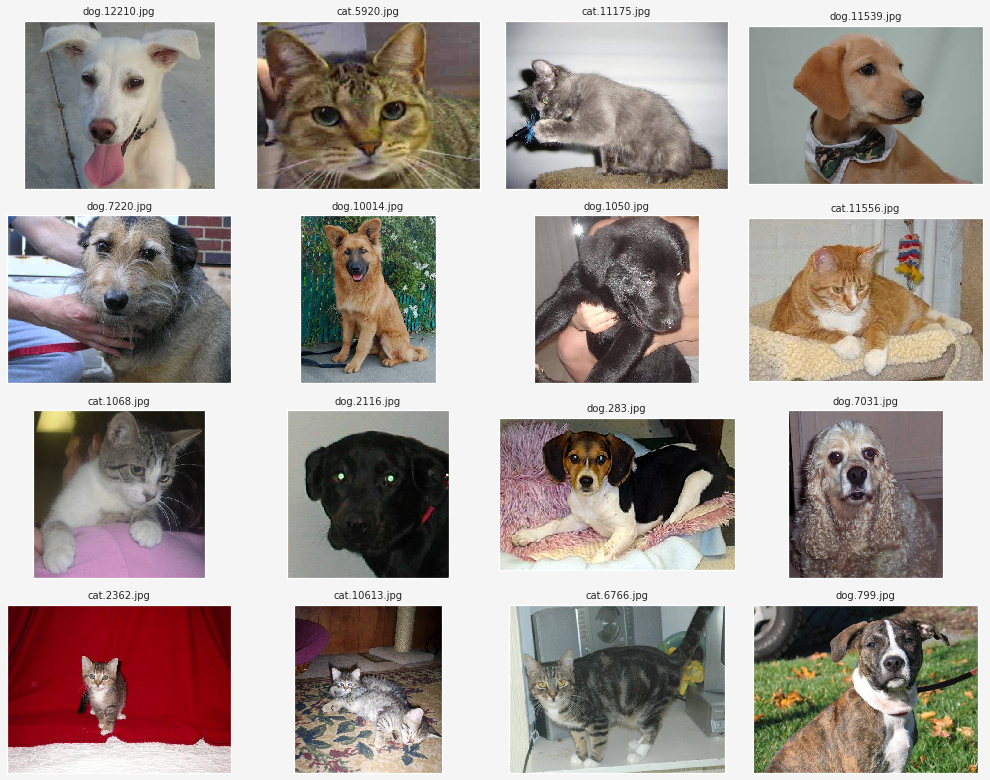

In [8]:
no_of_images = 4
path = 'train'

files = os.listdir(path)

for i in range(no_of_images * no_of_images):
    img = Image.open(path + os.sep + files[i])
    imgarr = np.asarray(img)
    img.close()

    plt.subplot(no_of_images, no_of_images, i+1)
    plt.imshow(X=imgarr)
    plt.title(files[i], fontsize=10)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.show();

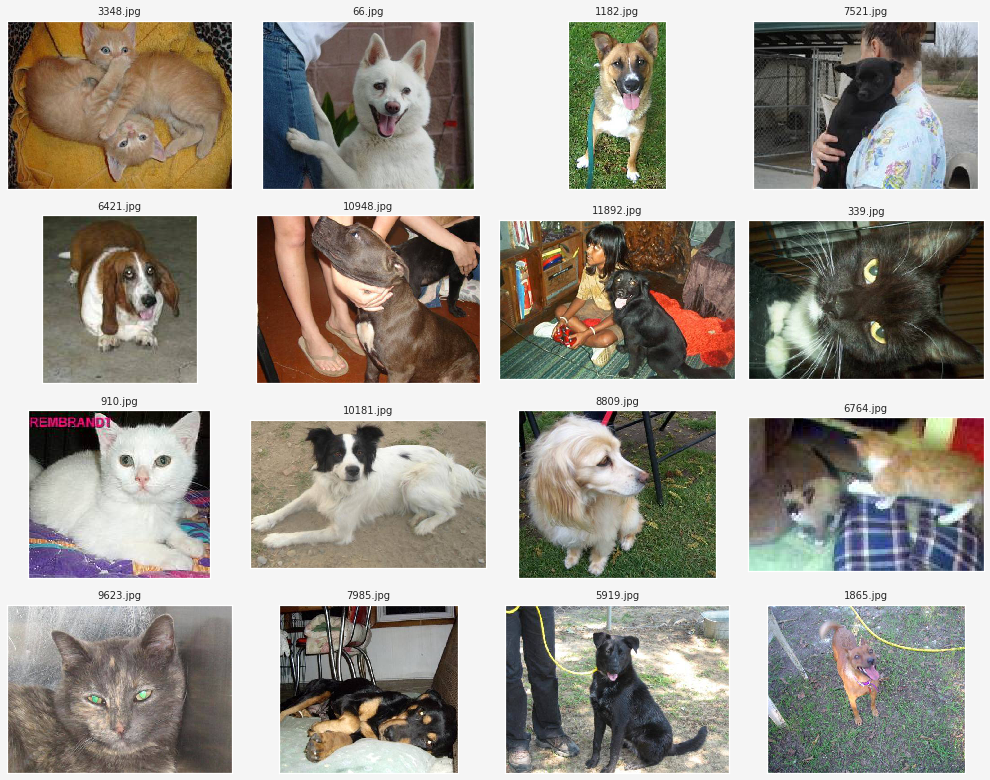

In [9]:
no_of_images = 4
path = 'test'

files = os.listdir(path)

for i in range(no_of_images * no_of_images):
    img = Image.open(path + os.sep + files[i])
    imgarr = np.asarray(img)
    img.close()

    plt.subplot(no_of_images, no_of_images, i+1)
    plt.imshow(X=imgarr)
    plt.title(files[i], fontsize=10)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.show();

## Display Image Dimensions

In [10]:
path = 'train'

for root, dirs, files in os.walk(path, topdown=True):
    for imgfile in files:
        try:
            img = Image.open(os.path.join(root, imgfile))
            img2arr = np.asarray(img, dtype=np.float32)
            print('{}: Shape of image {} is {}'.format(os.path.basename(root), imgfile, img2arr.shape))
        except:
            print('Bad file: ' + os.path.join(root, imgfile))
        
        # checking dimensions of only 1 file each from folder
        break;

train: Shape of image dog.12210.jpg is (336, 383, 3)


## Data Curation

In [0]:
image_size = 128
allpaths = ['train']
category = {'cat' : 0, 'dog' : 1}

In [12]:
train_feature, train_target = [], []

imgfiles = glob.glob('train/*.jpg', recursive=True)

for imgfile in tqdm.tqdm(imgfiles):
    img = Image.open(imgfile)
    img = img.resize((image_size, image_size))
    img2arr = np.array(img, dtype=np.float32) / 255.0
    img.close()
    train_feature.append(img2arr)
    if 'dog' in imgfile.lower():
        train_target.append(category.get('dog'))
    elif 'cat' in imgfile.lower():
        train_target.append(category.get('cat'))

train_feature = np.asarray(train_feature, dtype=np.float32)
train_target = np.asarray(train_target, dtype=np.int)

train_feature.shape, train_target.shape

100%|██████████| 25000/25000 [00:55<00:00, 447.25it/s]


((25000, 128, 128, 3), (25000,))

## Verify Data
Displaying a sample of the labels and images from the ndarray.

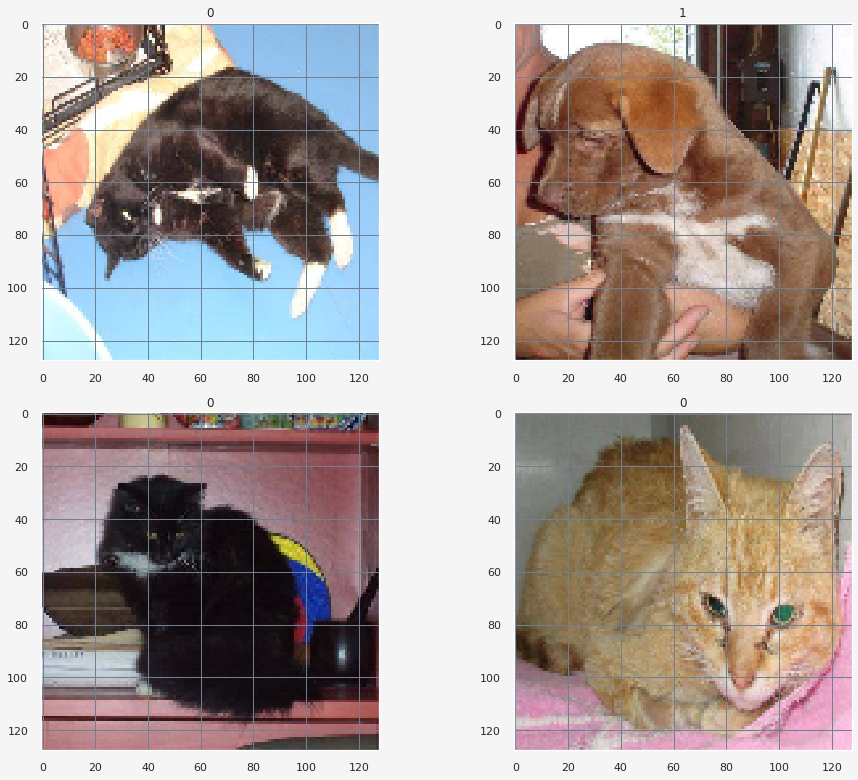

In [13]:
randomintergers = [random.randint(0, train_feature.shape[0]) for iter in range(4)]

plt.subplot(2, 2, 1)
plt.imshow(train_feature[randomintergers[0]])
plt.title(train_target[randomintergers[0]])
plt.grid(False);plt.xticks([]);plt.yticks([]);
plt.subplot(2, 2, 2)
plt.imshow(train_feature[randomintergers[1]])
plt.title(train_target[randomintergers[1]])
plt.grid(False);plt.xticks([]);plt.yticks([]);
plt.subplot(2, 2, 3)
plt.imshow(train_feature[randomintergers[2]])
plt.title(train_target[randomintergers[2]])
plt.grid(False);plt.xticks([]);plt.yticks([]);
plt.subplot(2, 2, 4)
plt.imshow(train_feature[randomintergers[3]])
plt.title(train_target[randomintergers[3]])
plt.grid(False);plt.xticks([]);plt.yticks([]);

plt.tight_layout()
plt.show()

## Plot Classes

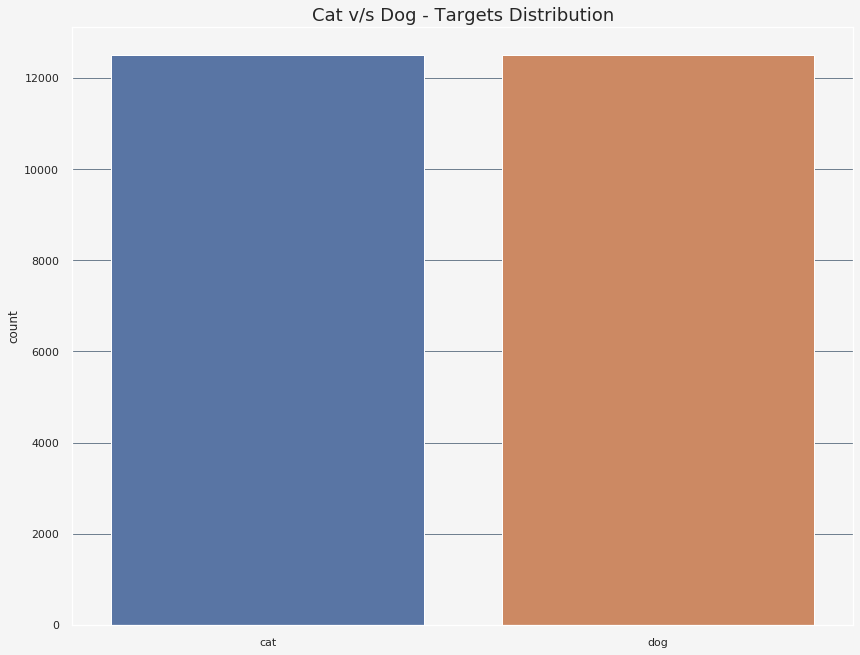

In [14]:
sns.countplot(x=train_target)
plt.xticks(np.arange(2), ('cat', 'dog'))
plt.title('Cat v/s Dog - Targets Distribution', fontsize=18)
plt.show()

## Feature Extraction from Pretrained Models

In [15]:
vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False)
resnet50 = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 4s 0us/step


In [0]:
def get_VGG16_features(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(image_size, image_size))
    img_data = tf.keras.preprocessing.image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = tf.keras.applications.imagenet_utils.preprocess_input(img_data)
    vgg16_features = vgg16.predict(img_data)
    return vgg16_features

def get_ResNet50_features(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(image_size, image_size))
    img_data = tf.keras.preprocessing.image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = tf.keras.applications.imagenet_utils.preprocess_input(img_data)
    resnet50_features = resnet50.predict(img_data)
    return resnet50_features

## Randomize the data

In [0]:
idx = np.random.permutation(len(train_target))

#train_feature, train_target = train_feature[idx], train_target[idx]

## Split Train and Test Data

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train_feature, train_target, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20000, 128, 128, 3), (5000, 128, 128, 3), (20000,), (5000,))

## Train Convolutional Neural Network (CNN) Model

In [19]:
# Set the input and output sizes
output_size = 1

# Filters
filters_128 = 128
filters_256 = 256
filters_512 = 512

# Kernel Size
kernel_size = (3, 3)

# Input Shape
input_shape = (image_size, image_size, 3)

# Pool Size
pool_size = (2, 2)

# Useing same hidden layer size for all hidden layers.
hidden_layer_size_256 = 256
hidden_layer_size_512 = 512

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=filters_512, kernel_size=kernel_size, padding='same', activation='relu', input_shape = input_shape))
model.add(tf.keras.layers.Conv2D(filters=filters_512, kernel_size=kernel_size, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=pool_size))
model.add(tf.keras.layers.Conv2D(filters=filters_256, kernel_size=kernel_size, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=pool_size))
model.add(tf.keras.layers.Conv2D(filters=filters_128, kernel_size=kernel_size, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=pool_size))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(hidden_layer_size_256, activation='relu'))
#model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.Dense(hidden_layer_size_512, activation='relu'))
model.add(tf.keras.layers.Dense(output_size, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 512)     14336     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 512)     2359808   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 512)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 256)       1179904   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       295040    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0

In [20]:
# Set a maximum number of training epochs
max_epochs = 25

# Set an early stopping mechanism
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=2)

history = model.fit(X_train, y_train, epochs=max_epochs, callbacks=[early_stopping], validation_split=0.2, verbose=2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/25
16000/16000 - 337s - loss: 0.7035 - accuracy: 0.5788 - val_loss: 0.6372 - val_accuracy: 0.6323
Epoch 2/25
16000/16000 - 328s - loss: 0.6008 - accuracy: 0.6761 - val_loss: 0.5472 - val_accuracy: 0.7230
Epoch 3/25
16000/16000 - 328s - loss: 0.5146 - accuracy: 0.7454 - val_loss: 0.4985 - val_accuracy: 0.7542
Epoch 4/25
16000/16000 - 327s - loss: 0.4450 - accuracy: 0.7895 - val_loss: 0.5303 - val_accuracy: 0.7510
Epoch 5/25
16000/16000 - 327s - loss: 0.3733 - accuracy: 0.8296 - val_loss: 0.4835 - val_accuracy: 0.7788
Epoch 6/25
16000/16000 - 327s - loss: 0.2905 - accuracy: 0.8773 - val_loss: 0.5698 - val_accuracy: 0.7678
Epoch 7/25
16000/16000 - 328s - loss: 0.2048 - accuracy: 0.9166 - val_loss: 0.7073 - val_accuracy: 0.7548
Epoch 8/25
16000/16000 - 327s - loss: 0.1138 - accuracy: 0.9567 - val_loss: 1.0033 - val_accuracy: 0.7448
Epoch 00008: early stopping


## Plot Model Performances

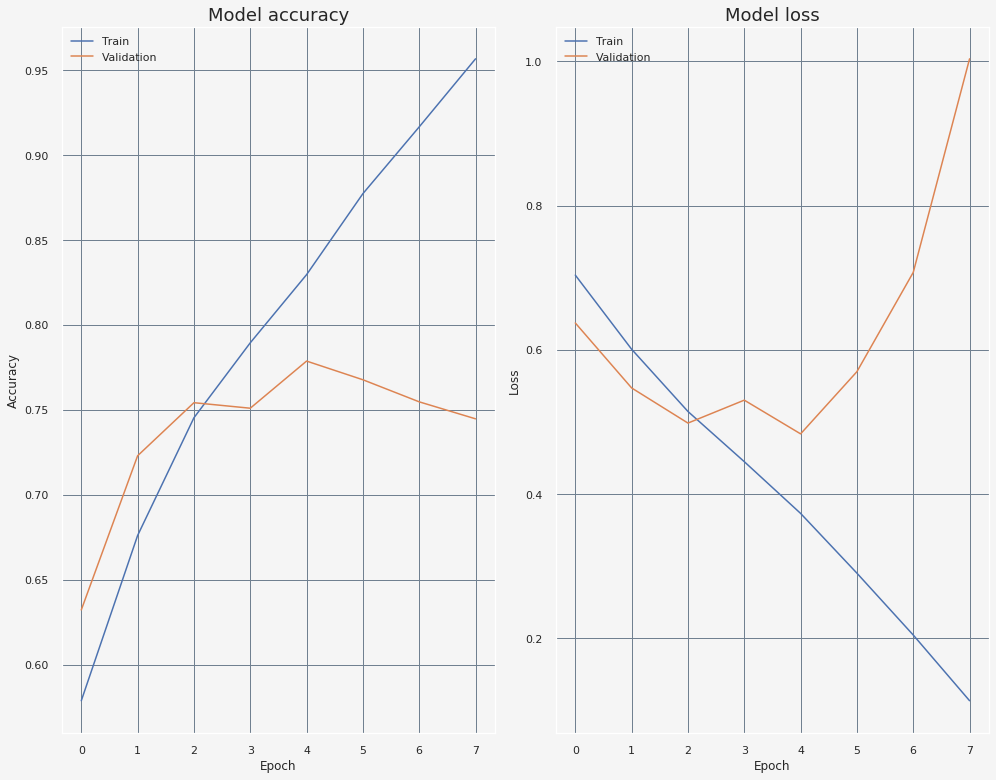

In [21]:
plt.subplot(1, 2, 1)
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy', fontsize=18)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss', fontsize=18)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

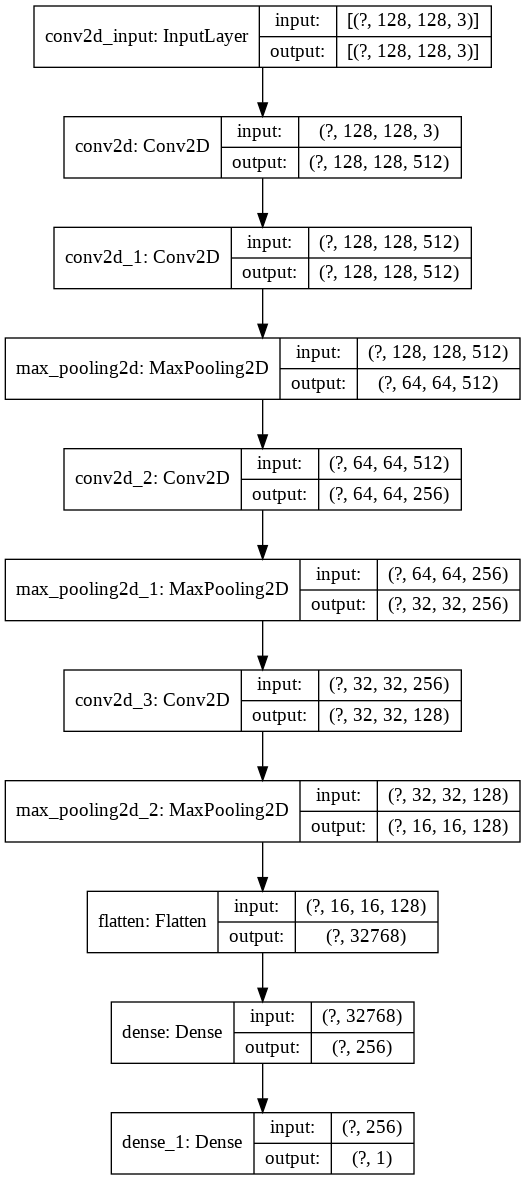

In [22]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96
)

## Calculate Accuracy on Test Data

In [23]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose = 0)

print('\nTest loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy * 100.0))


Test loss: 0.93. Test accuracy: 76.74%


## Predicting Test Data

In [0]:
predictions = model.predict_classes(X_test)

In [25]:
predictions.shape, y_test.shape

((5000, 1), (5000,))

In [26]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.74      0.83      0.78      2485
           1       0.81      0.70      0.75      2515

    accuracy                           0.77      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000



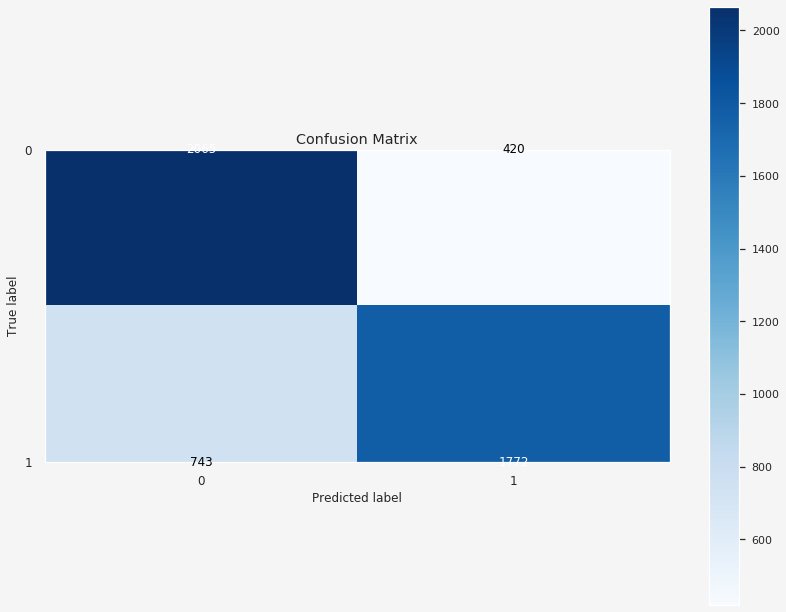

In [27]:
# cmap=mcolors.ListedColormap(mcolors.TABLEAU_COLORS)
skplt.metrics.plot_confusion_matrix(y_test, predictions);